In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import pyhf
import eos
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from redist import modifier
from redist import plot
from knunu_utils import * 

from copy import deepcopy

# Binning for $B \to K \nu \nu$ in terms of the WET

Here the differential branching ratio prediction is a function of one kinematic variable: $q^2$.

We use $q^2$ also as the fitting variable, but with a different binning than for the reweighting.

## Define the binning

In [2]:
binning = np.linspace(0.0, 22.9, 8+1) 
bin_cents = (binning[:-1] + binning[1:])/2

## Define the NP model in WC space

In [3]:
cvl = 12.0
cvr = 0.0
csl = 4.0
csr = 0.0
ctl = 5.0

## Compute number of samples to produce

In [4]:
# current lumi
lc = 362

# total lumi
lf = 50000

# current BB evts
ec = 387e6

# total BB evts
et = ec * lf / lc

## Generate some SM samples

In [5]:
p = analysis().parameters
k = eos.Kinematics(q2=1.0, q2_min=0.0, q2_max=22.90)
o = eos.Options(**{'form-factors': 'BSZ2015', 'model': 'WET'})

pdf = eos.SignalPDF.make('B^-->K^-nunu::dGamma/dq2', p, k, o)
obs = eos.Observable.make('B->Knunu::BR', p, k, o)
SMBR = obs.evaluate()

# SMsamples = int(ec*SMBR)
SMsamples = int(et*SMBR)

null_samples, pdf_values = pdf.sample_mcmc(SMsamples, stride=5, pre_N=10000, preruns=5, cov_scale=0.1, rng=np.random.mtrand.RandomState(seed=8888))

/home/l/Lorenz.Gaertner/micromamba/envs/redist/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Smear samples with Gaussian resolution function and apply efficiency


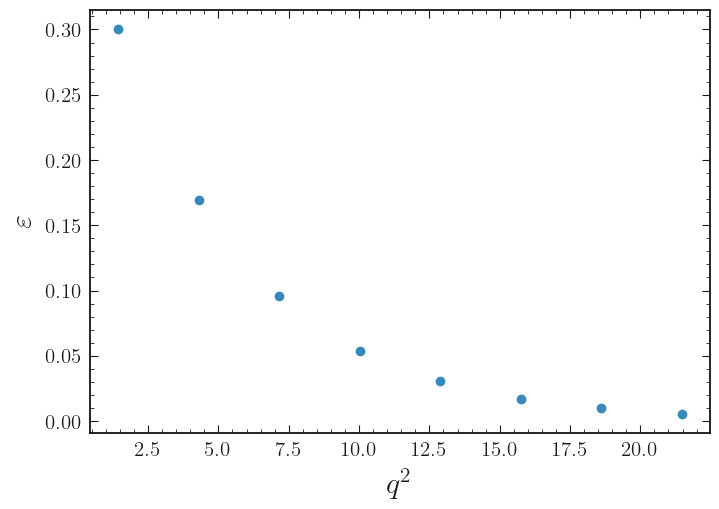

In [6]:
plt.plot(bin_cents, efficiency(bin_cents), "o")

plt.xlabel(r'$q^2$')
plt.ylabel(r'$\varepsilon$')
plt.show()

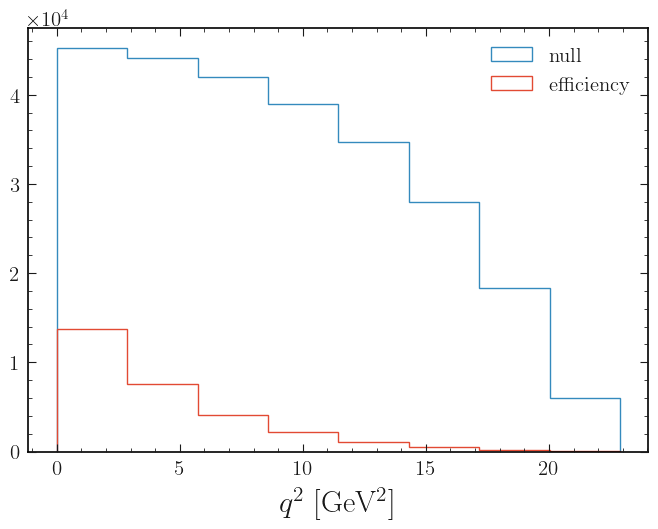

In [7]:
plt.hist(null_samples, binning, histtype='step', label='null')
null_yields, _, _ = plt.hist(null_samples, binning, weights = efficiency(null_samples), histtype='step', label='efficiency')

plt.xlabel(r'$q^2$ [GeV$^2$]')
plt.legend()

## Generate some fake data according to some NP model

Need to scale the number of samples here, because if NP would exist, we would also see a total different count of events.

In [8]:
p['sbnunu::Re{cVL}'].set(cvl)
p['sbnunu::Re{cVR}'].set(cvr)
p['sbnunu::Re{cSL}'].set(csl)
p['sbnunu::Re{cSR}'].set(csr)
p['sbnunu::Re{cTL}'].set(ctl)


BSMBR = obs.evaluate()

BSMsamples = int(SMsamples*BSMBR/SMBR)
alt_samples, pdf_values = pdf.sample_mcmc(BSMsamples, stride=5, pre_N=10000, preruns=5, cov_scale=0.1, rng=np.random.mtrand.RandomState(seed=9999))

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

### Smear samples with Gaussian resolution function and apply efficiency


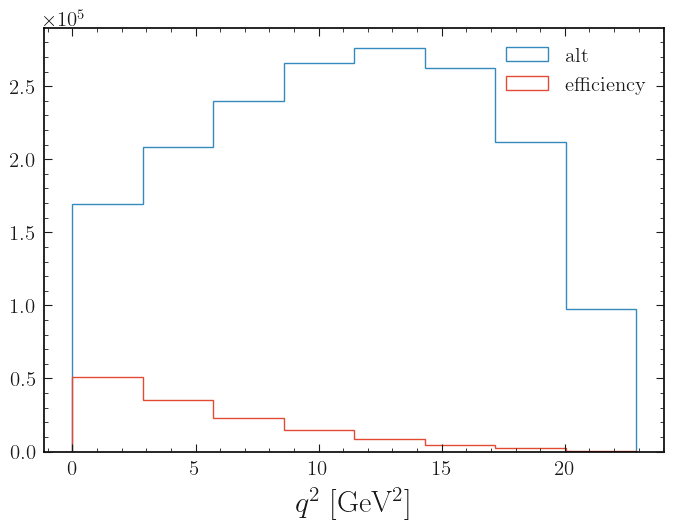

In [9]:
plt.hist(alt_samples, binning, histtype='step', label='alt')
alt_yields, _, _ = plt.hist(alt_samples, binning, weights = efficiency(alt_samples), histtype='step', label='efficiency')

plt.xlabel(r'$q^2$ [GeV$^2$]')
plt.legend()

## Setup

In [10]:
null = null_pred()
alt = alt_pred()

In [11]:
ana = analysis()

fp0 = ana.parameters['B->K::alpha^f+_0@BSZ2015'].evaluate()
fp1 = ana.parameters['B->K::alpha^f+_1@BSZ2015'].evaluate()
fp2 = ana.parameters['B->K::alpha^f+_2@BSZ2015'].evaluate()
f01 = ana.parameters['B->K::alpha^f0_1@BSZ2015'].evaluate()
f02 = ana.parameters['B->K::alpha^f0_2@BSZ2015'].evaluate()
fT0 = ana.parameters['B->K::alpha^fT_0@BSZ2015'].evaluate()
fT1 = ana.parameters['B->K::alpha^fT_1@BSZ2015'].evaluate()
fT2 = ana.parameters['B->K::alpha^fT_2@BSZ2015'].evaluate()

In [12]:
# Get covariance matrix of hadronic parameters
cov = parameter_cov(alt.ana, chains = 5, samples = 5000)
pd.DataFrame(cov).style.background_gradient(cmap='RdBu')

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

,0,1,2,3,4,5,6,7
0,0.000109,0.000696,0.000979,0.000775,0.001303,0.000088,0.000565,0.000760
1,0.000696,0.009307,0.021609,0.005688,0.010247,0.000392,0.006202,0.014710
2,0.000979,0.021609,0.067185,0.008526,0.017058,0.000097,0.011229,0.042544
3,0.000775,0.005688,0.008526,0.006233,0.011288,0.000612,0.004714,0.006588
4,0.001303,0.010247,0.017058,0.011288,0.022037,0.000978,0.008112,0.012782
5,0.000088,0.000392,0.000097,0.000612,0.000978,0.000473,0.003446,0.005830
6,0.000565,0.006202,0.011229,0.004714,0.008112,0.003446,0.031871,0.061918
7,0.000760,0.014710,0.042544,0.006588,0.012782,0.005830,0.061918,0.144128


In [13]:
cvlSM = eos.Parameters()['sbnunu::Re{cVL}'].evaluate()

new_params = {
                'cvl' : {'inits': (cvlSM,),  'bounds': ((3., 14.),), 'paramset_type': 'unconstrained'},
                'cvr' : {'inits': (0.001, ), 'bounds': ((0., 10.),), 'paramset_type': 'unconstrained'},
                'csl' : {'inits': (0.001, ), 'bounds': ((0., 10.),), 'paramset_type': 'unconstrained'},
                'csr' : {'inits': (0.001, ), 'bounds': ((0., 10.),), 'paramset_type': 'unconstrained'},
                'ctl' : {'inits': (0.001, ), 'bounds': ((0., 10.),), 'paramset_type': 'unconstrained'},
                'FFK' : {'inits': (fp0, fp1, fp2, f01, f02, fT0, fT1, fT2), 
                         'bounds': (), 
                         'cov': cov, 
                         'paramset_type': 'constrained_by_normal'}
            }

In [18]:
spec = {
  "channels": [
    {
      "name": "B->Knunu",
      "samples": [
        {
          "name": "signal",
          "data": null_yields.tolist(),
          "modifiers": [
            {
                "name": "mu",
                "type": "normfactor",
                "data": None
            },
            {
                "name": "stat",
                "type": "staterror",
                "data": np.sqrt(null_yields).tolist()
            }
          ]
        },
      ]
    }
  ]
}
basemodel = pyhf.Model(spec)

custom_mod = {
                "name": "knunu_theory",
                "type": "knunu",
                "data":{"expr": "knunu_weight_fn"}
              }

## Check convergence for different binnings

In [19]:
max_bins = 0

#loop random  models
for m in range(100):
    np.random.seed(123+m)
    cvl, csl, ctl = np.random.normal(0.0, 10.0, 3)
    cvl += cvlSM
    
    old = None
    #loop over number of bins
    for n in range(1, 30):
        q2binning = np.linspace(0.0, 22.9, n+1)

        mapping_dist = modifier.map(null_samples.flatten(), [null_samples.flatten()], binning, [q2binning])
        mapping_dist = mapping_dist * efficiency(bin_cents)[:,np.newaxis]

        cmod = modifier.Modifier(new_params, alt.distribution, null.distribution, mapping_dist, [q2binning.tolist()], name='knunu')

        model = modifier.add_to_model(deepcopy(basemodel), ['B->Knunu'], ['signal'], cmod.expanded_pyhf, custom_mod)
        
        init = model.config.suggested_init()
        init[model.config.par_map['cvl']['slice']] = [cvl]
        init[model.config.par_map['cvr']['slice']] = [0]
        init[model.config.par_map['csl']['slice']] = [csl]
        init[model.config.par_map['csr']['slice']] = [0]
        init[model.config.par_map['ctl']['slice']] = [ctl]
        
        try:
            new = model.expected_actualdata(init)
            diff = abs(new-old)/old
            # check if the difference is larger than 1%
            if not any(diff > 1e-2):
                max_bins = max(max_bins, n)
                break
        except:
            pass
        
        old = model.expected_actualdata(init)
        
print('max bins', max_bins)

max bins 22


## Compare to data

1 [0.79468104 0.4236214  0.17394288 0.0224536  0.16388534 0.29443677
 0.43048479 0.61531964]
2 [0.38483085 0.09849515 0.09404185 0.24554224 0.20926535 0.02025048
 0.17711936 0.44625235]
3 [0.21470745 0.03646046 0.04915092 0.06532109 0.08882553 0.0400625
 0.03887875 0.35400629]
4 [0.12982577 0.10379546 0.08915872 0.09303368 0.0690361  0.09800833
 0.06670708 0.28355031]
5 [0.07917322 0.01184277 0.01942449 0.0164591  0.03516699 0.00313258
 0.0083726  0.22239069]
6 [0.04555602 0.01122783 0.01155374 0.03956291 0.01697155 0.00475836
 0.0344655  0.1660863 ]
7 [0.02162729 0.0097165  0.00455012 0.0111557  0.00992168 0.01950623
 0.04119225 0.11264966]
8 [0.00372969 0.00120484 0.00087371 0.01230236 0.00861637 0.01723264
 0.0386948  0.06105387]
9 [0.01424278 0.00600533 0.00178937 0.01162839 0.00952616 0.01932385
 0.04442011 0.08107919]
10 [0.01857203 0.00325528 0.00467195 0.02230281 0.00112549 0.0129335
 0.0407504  0.09073048]
11 [0.01911584 0.00331411 0.00472795 0.00672579 0.01428739 0.01242976
 

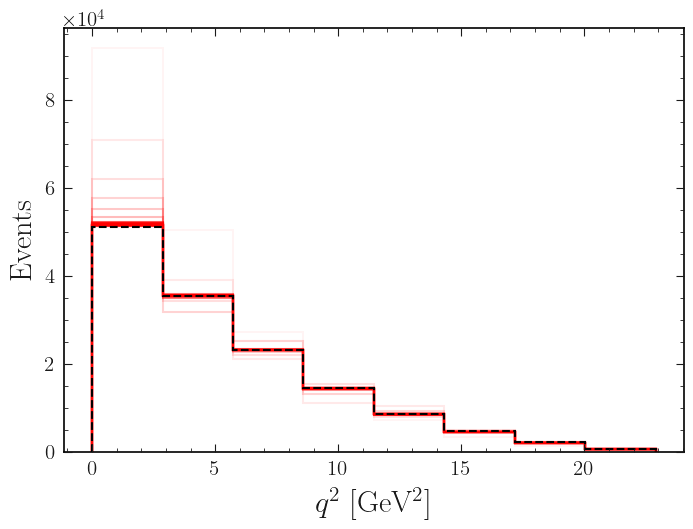

In [33]:
#loop over number of bins
maxbins = 23
for n in range(1, maxbins):
    q2binning = np.linspace(0.0, 22.9, n+1)

    mapping_dist = modifier.map(null_samples.flatten(), [null_samples.flatten()], binning, [q2binning])
    mapping_dist = mapping_dist * efficiency(bin_cents)[:,np.newaxis]

    cmod = modifier.Modifier(new_params, alt.distribution, null.distribution, mapping_dist, [q2binning.tolist()], name='knunu')

    model = modifier.add_to_model(deepcopy(basemodel), ['B->Knunu'], ['signal'], cmod.expanded_pyhf, custom_mod)
    
    init = model.config.suggested_init()
    init[model.config.par_map['cvl']['slice']] = [12.]
    init[model.config.par_map['cvr']['slice']] = [0]
    init[model.config.par_map['csl']['slice']] = [4.]
    init[model.config.par_map['csr']['slice']] = [0]
    init[model.config.par_map['ctl']['slice']] = [5.]
    
    new = model.expected_actualdata(init)

    plt.stairs(new, binning, color='r', alpha=n/maxbins, linewidth=1.5)
    
    print(n, abs(new-alt_yields)/alt_yields)

plt.stairs(alt_yields, binning, color='k', linestyle='dashed', linewidth=1.5)

plt.xlabel(r'$q^2$ [GeV$^2$]')
plt.ylabel(r'Events')

plt.show()

In [32]:
1/np.sqrt(alt_yields)

array([0.00442476, 0.00531182, 0.00658006, 0.00830653, 0.01083584,
       0.01474934, 0.02175526, 0.0414841 ])

In [28]:
binning

array([ 0.    ,  2.8625,  5.725 ,  8.5875, 11.45  , 14.3125, 17.175 ,
       20.0375, 22.9   ])

In [29]:
q2binning

array([ 0.        ,  1.04090909,  2.08181818,  3.12272727,  4.16363636,
        5.20454545,  6.24545455,  7.28636364,  8.32727273,  9.36818182,
       10.40909091, 11.45      , 12.49090909, 13.53181818, 14.57272727,
       15.61363636, 16.65454545, 17.69545455, 18.73636364, 19.77727273,
       20.81818182, 21.85909091, 22.9       ])